# Image Space Projection using Autoencoders
![](./images/faces.gif)

In this example we are going to autoencode the faces of the olivetti dataset and try to reconstruct them back.

In [27]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [28]:
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,56 mins 14 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,2 days
H2O cluster name:,H2O_from_python_fmilo_kidv81
H2O cluster total nodes:,1
H2O cluster free memory:,12.77 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

In [9]:
!wget -S http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z

--2016-10-09 09:57:09--  http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z
Resolving www.cl.cam.ac.uk (www.cl.cam.ac.uk)... 128.232.0.20, 2001:630:212:200::80:14
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:80... connected.
HTTP request sent, awaiting response... 
  HTTP/1.1 301 Moved Permanently
  Date: Sun, 09 Oct 2016 16:57:09 GMT
  Server: Apache/2.4.18 (Ubuntu)
  Location: http://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.tar.Z
  Content-Length: 362
  Keep-Alive: timeout=5, max=100
  Connection: Keep-Alive
  Content-Type: text/html; charset=iso-8859-1
Location: http://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.tar.Z [following]
--2016-10-09 09:57:09--  http://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.tar.Z
Reusing existing connection to www.cl.cam.ac.uk:80.
HTTP request sent, awaiting response... 
  HTTP/1.1 200 OK
  Date: Sun, 09 Oct 2016 16:57:09 GMT
  Server: Apache/2.2.22 (Debian)
  L

In [11]:
!tar xzvf att_faces.tar.Z;rm att_faces.tar.Z;

orl_faces/
orl_faces/README
orl_faces/s1/
orl_faces/s1/6.pgm
orl_faces/s1/7.pgm
orl_faces/s1/8.pgm
orl_faces/s1/9.pgm
orl_faces/s1/10.pgm
orl_faces/s1/1.pgm
orl_faces/s1/2.pgm
orl_faces/s1/3.pgm
orl_faces/s1/4.pgm
orl_faces/s1/5.pgm
orl_faces/s2/
orl_faces/s2/6.pgm
orl_faces/s2/7.pgm
orl_faces/s2/8.pgm
orl_faces/s2/9.pgm
orl_faces/s2/10.pgm
orl_faces/s2/1.pgm
orl_faces/s2/2.pgm
orl_faces/s2/3.pgm
orl_faces/s2/4.pgm
orl_faces/s2/5.pgm
orl_faces/s3/
orl_faces/s3/6.pgm
orl_faces/s3/7.pgm
orl_faces/s3/8.pgm
orl_faces/s3/9.pgm
orl_faces/s3/10.pgm
orl_faces/s3/1.pgm
orl_faces/s3/2.pgm
orl_faces/s3/3.pgm
orl_faces/s3/4.pgm
orl_faces/s3/5.pgm
orl_faces/s4/
orl_faces/s4/6.pgm
orl_faces/s4/7.pgm
orl_faces/s4/8.pgm
orl_faces/s4/9.pgm
orl_faces/s4/10.pgm
orl_faces/s4/1.pgm
orl_faces/s4/2.pgm
orl_faces/s4/3.pgm
orl_faces/s4/4.pgm
orl_faces/s4/5.pgm
orl_faces/s5/
orl_faces/s5/6.pgm
orl_faces/s5/7.pgm
orl_faces/s5/8.pgm
orl_faces/s5/9.pgm
orl_faces/s5/10.pgm
orl_faces/s5/1.pgm
orl_faces/s5/2.pgm
orl_

We now need some code to read pgm files.
Thanks to [StackOverflow](http://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm) we have some code to leverage:

In [29]:
import re

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


In [30]:
image = read_pgm("orl_faces/s12/6.pgm", byteorder='<')

In [31]:
image.shape

(112, 92)

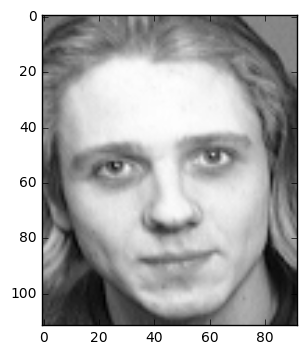

In [32]:
plt.imshow(image, plt.cm.gray)
plt.show()

In [33]:
import glob
import os
from collections import defaultdict

In [34]:
images = glob.glob("orl_faces/**/*.pgm")

data = defaultdict(list)
image_data = []
for img in images:
    _,label,_ = img.split(os.path.sep)
    imgdata = read_pgm(img, byteorder='<').flatten().tolist()
    data[label].append(imgdata)
    image_data.append(imgdata)

Let's import it to H2O

In [35]:
faces = h2o.H2OFrame.from_python(image_data)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [36]:
faces.shape

(400, 10304)

In [37]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator

In [38]:
model = H2OAutoEncoderEstimator( 
        activation="Tanh", 
        hidden=[500, 100, 500], 
        sparse=True,
        l1=1e-4, 
        epochs=100
)

model.train(x=faces.names, training_frame=faces)

deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%


## Reconstructing the hidden space

Now that we have our model trained, we would like to understand better what is the internal representation of this model? What makes a face a .. face? 

We will provide to the model some gaussian noise and see what is the results.

We star by creating some gaussian noise:

In [42]:
import pandas as pd

In [43]:
gaussian_noise = np.random.randn(10304)

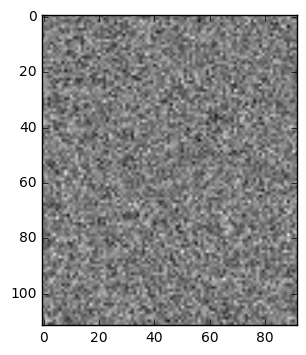

In [44]:
plt.imshow(gaussian_noise.reshape(112, 92), plt.cm.gray);

Then we import this data inside H2O. We have to first map the columns to the gaussian data.

In [45]:
gaussian_noise_pre = dict(zip(faces.names,gaussian_noise))

In [46]:
gaussian_noise_hf = h2o.H2OFrame.from_python(gaussian_noise_pre)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [47]:
result = model.anomaly(gaussian_noise_hf)

In [48]:
result = model.predict(gaussian_noise_hf)

deeplearning prediction progress: |███████████████████████████████████████████████████████████| 100%


In [49]:
result.shape

(1, 10304)

In [50]:
img = result.as_data_frame()

In [51]:
img_data = img.T.values.reshape(112, 92)

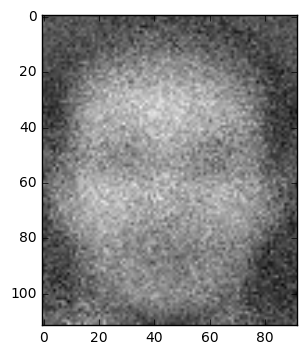

In [52]:
plt.imshow(img_data, plt.cm.gray);

# Conclusions

## TODO

In [1]:
!jupyter nbconvert --to markdown deeplearning_image_reconstruction_and_clustering.ipynb

[NbConvertApp] Converting notebook deeplearning_image_reconstruction_and_clustering.ipynb to markdown
[NbConvertApp] Support files will be in deeplearning_image_reconstruction_and_clustering_files/
[NbConvertApp] Making directory deeplearning_image_reconstruction_and_clustering_files
[NbConvertApp] Making directory deeplearning_image_reconstruction_and_clustering_files
[NbConvertApp] Making directory deeplearning_image_reconstruction_and_clustering_files
[NbConvertApp] Writing 17435 bytes to deeplearning_image_reconstruction_and_clustering.md
